## Part 1 - Prepocessing real world data from Data.World showing the crimes in New York from 2016

<b>New York Crime Data</b>

Table column information:
* CMPLNT_NUM: Randomly generated persistent ID for each complaint
* ADDR_PCT_CD: The precinct in which the incident occurred
* BORO_NM: The name of the borough in which the incident occurred
* CMPLNT_FR_DT: Exact date of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists)
* CMPLNT_FR_TM: Exact time of occurrence for the reported event (or starting time of occurrence, if CMPLNT_TO_TM exists)
* CMPLNT_TO_DT: Ending date of occurrence for the reported event, if exact time of occurrence is unknown
* CMPLNT_TO_TM: Ending time of occurrence for the reported event, if exact time of occurrence is unknown
* CRM_ATPT_CPTD_CD: Indicator of whether crime was successfully completed or attempted, but failed or was interrupted prematurely
* HADEVELOPT: Name of NYCHA housing development of occurrence, if applicable
* HOUSING_PSA: Development Level Code
* JURISDICTION_CODE: Jurisdiction responsible for incident. Either internal, like Police(0), * Transit(1), and Housing(2); or external(3), like Correction, Port Authority, etc.
* JURIS_DESC: Description of the jurisdiction code
* KY_CD: Three digit offense classification code
* LAW_CAT_CD: Level of offense: felony, misdemeanor, violation
* LOC_OF_OCCUR_DESC: Specific location of occurrence in or around the premises; inside, opposite of, front of, rear of
* OFNS_DESC: Description of offense corresponding with key code
* PARKS_NM: Name of NYC park, playground or greenspace of occurrence, if applicable (state parks are not included)
* PATROL_BORO: The name of the patrol borough in which the incident occurred
* PD_CD: Three digit internal classification code (more granular than Key Code)
* PD_DESC: Description of internal classification corresponding with PD code (more granular than Offense Description)
* PREM_TYP_DESC: Specific description of premises; grocery store, residence, street, etc.
* RPT_DT	: Date event was reported to police
* STATION_NAME: Transit station name
* SUSP_AGE_GROUP: Suspect’s Age Group
* SUSP_RACE: Suspect’s Race Description
* SUSP_SEX: Suspect’s Sex Description
* TRANSIT_DISTRICT: Transit district in which the offense occurred.
* VIC_AGE_GROUP: Victim’s Age Group
* VIC_RACE: Victim’s Race Description
* VIC_SEX: Victim’s Sex Description
* X_COORD_CD: X-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)
* Y_COORD_CD: Y-coordinate for New York State Plane Coordinate System, Long Island Zone, NAD 83, units feet (FIPS 3104)
* Latitude: Midblock Latitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)
* Longitude: Midblock Longitude coordinate for Global Coordinate System, WGS 1984, decimal degrees (EPSG 4326)

Data set URL: https://data.world/data-society/nyc-crime-data


<b>Import necessary libraries</b>

In [51]:
import requests 
import pandas as pd 
import numpy as np 
import random 

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
mpl.style.use('ggplot') 

import geocoder

from geopy.geocoders import Nominatim 

from IPython.core.display import HTML 
from pandas.io.json import json_normalize

import folium

<b>Defining Foursquare Credentials and Version</b>

In [2]:
CLIENT_ID = 'GCPVRNJL2PLRHE44UFDHVKMI2DAKPNFYZTHZ1W0JSBB1RHLD'
CLIENT_SECRET = 'CE5EPQQT54EOICC0FVIHITYWXUS4J1M5QKMPUKQLCVPTYDPD' 
VERSION = '20180605' 
LIMIT = 100 

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: GCPVRNJL2PLRHE44UFDHVKMI2DAKPNFYZTHZ1W0JSBB1RHLD
CLIENT_SECRET:CE5EPQQT54EOICC0FVIHITYWXUS4J1M5QKMPUKQLCVPTYDPD


<b>Read the dataset</b>

In [3]:
df = pd.read_csv('NYPD_Complaint_Data_Current_YTD.csv')
df.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,RPT_DT,KY_CD,OFNS_DESC,PD_CD,PD_DESC,...,ADDR_PCT_CD,LOC_OF_OCCUR_DESC,PREM_TYP_DESC,PARKS_NM,HADEVELOPT,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lat_Lon
0,736216184,09/30/2016,23:25:00,09/30/2016,23:25:00,09/30/2016,236,DANGEROUS WEAPONS,782.0,"WEAPONS, POSSESSION, ETC",...,42.0,NaN,TRANSIT - NYC SUBWAY,NaN,NaN,1015308.0,244373.0,40.837376,-73.887761,"(40.837376359, -73.887760929)"
1,294332956,09/30/2016,23:16:00,09/30/2016,23:21:00,09/30/2016,344,ASSAULT 3 & RELATED OFFENSES,101.0,ASSAULT 3,...,71.0,OPPOSITE OF,STREET,NaN,NaN,997932.0,180172.0,40.661205,-73.950687,"(40.661204871, -73.950686652)"
2,852981427,09/30/2016,23:00:00,09/30/2016,23:05:00,09/30/2016,235,DANGEROUS DRUGS,567.0,"MARIJUANA, POSSESSION 4 & 5",...,43.0,INSIDE,RESIDENCE - PUBLIC HOUSING,NaN,CASTLE HILL,1025580.0,236918.0,40.816872,-73.850685,"(40.816872438, -73.850684927)"
3,369976063,09/30/2016,23:00:00,NaN,NaN,09/30/2016,118,DANGEROUS WEAPONS,793.0,WEAPONS POSSESSION 3,...,103.0,NaN,STREET,NaN,NaN,1038464.0,192970.0,40.696177,-73.804492,"(40.696177006, -73.804492266)"
4,117213771,09/30/2016,23:00:00,09/30/2016,23:10:00,09/30/2016,578,HARRASSMENT 2,637.0,"HARASSMENT,SUBD 1,CIVILIAN",...,110.0,FRONT OF,STREET,NaN,NaN,1016301.0,209428.0,40.741458,-73.884339,"(40.741458245, -73.884339073)"


<b>Drop Columns</b>

In [4]:
df.drop(columns=['CMPLNT_NUM', 'CMPLNT_FR_DT', 'CMPLNT_FR_TM', 'CMPLNT_TO_DT', 'CMPLNT_TO_TM', 'LAW_CAT_CD', 'RPT_DT',
                 'KY_CD', 'PD_CD','PD_DESC', 'CRM_ATPT_CPTD_CD', 'JURIS_DESC', 'ADDR_PCT_CD', 'LOC_OF_OCCUR_DESC',
                 'PREM_TYP_DESC', 'PARKS_NM',  'HADEVELOPT', 'X_COORD_CD', 'Y_COORD_CD', 'Lat_Lon', 'Latitude', 'Longitude' ], axis=1, inplace=True)

In [5]:
df.head()

,OFNS_DESC,BORO_NM
0,DANGEROUS WEAPONS,BRONX
1,ASSAULT 3 & RELATED OFFENSES,BROOKLYN
2,DANGEROUS DRUGS,BRONX
3,DANGEROUS WEAPONS,QUEENS
4,HARRASSMENT 2,QUEENS


<b>Change column names</b>

In [6]:
df.columns = ['Crime_Category','Borough'] 
df.head(15)

,Crime_Category,Borough
0,DANGEROUS WEAPONS,BRONX
1,ASSAULT 3 & RELATED OFFENSES,BROOKLYN
2,DANGEROUS DRUGS,BRONX
3,DANGEROUS WEAPONS,QUEENS
4,HARRASSMENT 2,QUEENS
5,DANGEROUS WEAPONS,BROOKLYN
6,DANGEROUS WEAPONS,BRONX
7,DANGEROUS DRUGS,MANHATTAN
8,DANGEROUS DRUGS,MANHATTAN
9,DANGEROUS DRUGS,BRONX


In [7]:
df.shape

(361740, 2)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 361740 entries, 0 to 361739
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Crime_Category  361702 non-null  object
 1   Borough         361740 non-null  object
dtypes: object(2)
memory usage: 5.5+ MB


<b>Number of crimes for each crime category in each borough</b>

In [9]:
df1 = df.groupby('Borough')['Crime_Category'].value_counts().unstack().fillna(0)
df1 = df1.astype('int')
df1

Crime_Category,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CHILD ABANDONMENT/NON SUPPORT,...,POSSESSION OF STOLEN PROPERTY,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS
Borough,,,,,,,,,,,,,,,,,,,,,
BRONX,170,0,22,32,0,170,10300,27,1947,6,...,208,68,265,3149,938,144,644,142,0,1030
BROOKLYN,312,0,31,34,0,163,12171,52,3099,3,...,391,19,337,3603,1416,9,972,470,1,1311
MANHATTAN,64,0,28,7,2,109,7903,79,1824,4,...,364,7,220,2185,1376,160,1110,129,0,815
QUEENS,176,1,21,2,0,135,7942,45,2401,3,...,251,5,249,2237,868,14,780,512,1,1661
STATEN ISLAND,37,0,6,0,0,36,1661,2,364,0,...,51,3,36,298,141,0,197,85,0,133


In [10]:
df1.reset_index(inplace=True)

In [11]:
df1['Total'] = df1.sum(axis=1)
df1.head()

Crime_Category,Borough,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,...,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS,Total
0,BRONX,170,0,22,32,0,170,10300,27,1947,...,68,265,3149,938,144,644,142,0,1030,80267
1,BROOKLYN,312,0,31,34,0,163,12171,52,3099,...,19,337,3603,1416,9,972,470,1,1311,106202
2,MANHATTAN,64,0,28,7,2,109,7903,79,1824,...,7,220,2185,1376,160,1110,129,0,815,87339
3,QUEENS,176,1,21,2,0,135,7942,45,2401,...,5,249,2237,868,14,780,512,1,1661,71373
4,STATEN ISLAND,37,0,6,0,0,36,1661,2,364,...,3,36,298,141,0,197,85,0,133,16521


In [12]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 62 columns):
 #   Column                                Non-Null Count  Dtype 
---  ------                                --------------  ----- 
 0   Borough                               5 non-null      object
 1   ADMINISTRATIVE CODE                   5 non-null      int32 
 2   ADMINISTRATIVE CODES                  5 non-null      int32 
 3   AGRICULTURE & MRKTS LAW-UNCLASSIFIED  5 non-null      int32 
 4   ALCOHOLIC BEVERAGE CONTROL LAW        5 non-null      int32 
 5   ANTICIPATORY OFFENSES                 5 non-null      int32 
 6   ARSON                                 5 non-null      int32 
 7   ASSAULT 3 & RELATED OFFENSES          5 non-null      int32 
 8   BURGLAR'S TOOLS                       5 non-null      int32 
 9   BURGLARY                              5 non-null      int32 
 10  CHILD ABANDONMENT/NON SUPPORT         5 non-null      int32 
 11  CRIMINAL MISCHIEF & RELATED OF      

In [13]:
df1.shape

(5, 62)

<b>Creating total crimes per borough column</b>

In [14]:
df1.sort_values(['Total'], ascending = False, axis = 0, inplace = True )

df1_top5 = df1.head() 
df1_top5

Crime_Category,Borough,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,...,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS,Total
1,BROOKLYN,312,0,31,34,0,163,12171,52,3099,...,19,337,3603,1416,9,972,470,1,1311,106202
2,MANHATTAN,64,0,28,7,2,109,7903,79,1824,...,7,220,2185,1376,160,1110,129,0,815,87339
0,BRONX,170,0,22,32,0,170,10300,27,1947,...,68,265,3149,938,144,644,142,0,1030,80267
3,QUEENS,176,1,21,2,0,135,7942,45,2401,...,5,249,2237,868,14,780,512,1,1661,71373
4,STATEN ISLAND,37,0,6,0,0,36,1661,2,364,...,3,36,298,141,0,197,85,0,133,16521


## Part 2 - Exploratory Data Analysis

<b>Descriptive statistics of the data</b>

In [15]:
df1.describe().astype('int')

Crime_Category,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,CHILD ABANDONMENT/NON SUPPORT,...,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS,Total
count,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,5,5,5,5
mean,151,0,21,15,0,122,7995,41,1927,3,...,20,221,2294,947,65,740,267,0,990,72340
std,108,0,9,16,0,54,3964,28,1006,2,...,27,112,1269,514,79,352,205,0,574,33731
min,37,0,6,0,0,36,1661,2,364,0,...,3,36,298,141,0,197,85,0,133,16521
25%,64,0,21,2,0,109,7903,27,1824,3,...,5,220,2185,868,9,644,129,0,815,71373
50%,170,0,22,7,0,135,7942,45,1947,3,...,7,249,2237,938,14,780,142,0,1030,80267
75%,176,0,28,32,0,163,10300,52,2401,4,...,19,265,3149,1376,144,972,470,1,1311,87339
max,312,1,31,34,2,170,12171,79,3099,6,...,68,337,3603,1416,160,1110,512,1,1661,106202


<b>Visualize the boroughs with the highest number of crimes</b>

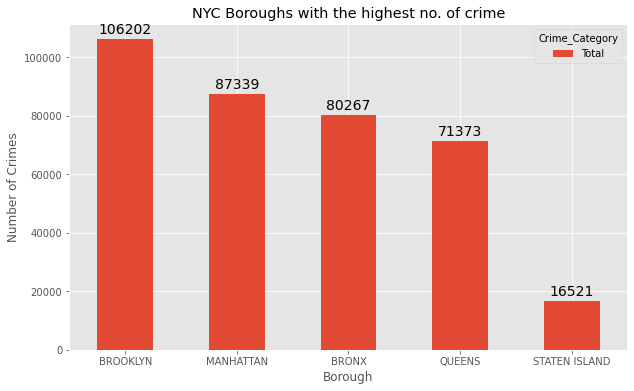

In [16]:
df_bt = df1_top5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') 
ax.set_xlabel('Borough') 
ax.set_title('NYC Boroughs with the highest no. of crime') 


for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

<b>Visualize the five boroughs with the lowest number of crimes</b>

In [17]:
df1.sort_values(['Total'], ascending = True, axis = 0, inplace = True )
df1_bot5 = df1.head() 
df1_bot5

Crime_Category,Borough,ADMINISTRATIVE CODE,ADMINISTRATIVE CODES,AGRICULTURE & MRKTS LAW-UNCLASSIFIED,ALCOHOLIC BEVERAGE CONTROL LAW,ANTICIPATORY OFFENSES,ARSON,ASSAULT 3 & RELATED OFFENSES,BURGLAR'S TOOLS,BURGLARY,...,PROSTITUTION & RELATED OFFENSES,RAPE,ROBBERY,SEX CRIMES,THEFT OF SERVICES,THEFT-FRAUD,UNAUTHORIZED USE OF A VEHICLE,UNLAWFUL POSS. WEAP. ON SCHOOL,VEHICLE AND TRAFFIC LAWS,Total
4,STATEN ISLAND,37,0,6,0,0,36,1661,2,364,...,3,36,298,141,0,197,85,0,133,16521
3,QUEENS,176,1,21,2,0,135,7942,45,2401,...,5,249,2237,868,14,780,512,1,1661,71373
0,BRONX,170,0,22,32,0,170,10300,27,1947,...,68,265,3149,938,144,644,142,0,1030,80267
2,MANHATTAN,64,0,28,7,2,109,7903,79,1824,...,7,220,2185,1376,160,1110,129,0,815,87339
1,BROOKLYN,312,0,31,34,0,163,12171,52,3099,...,19,337,3603,1416,9,972,470,1,1311,106202


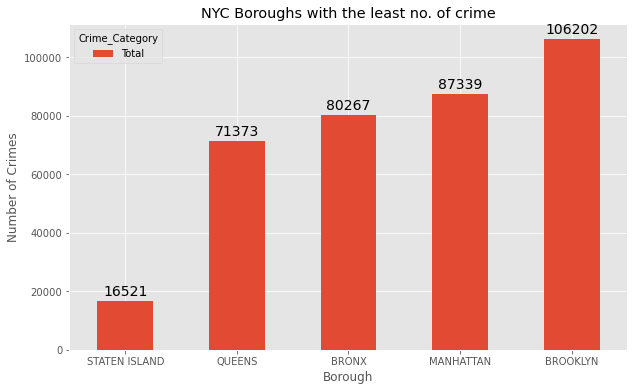

In [18]:
df_bt = df1_bot5[['Borough','Total']]

df_bt.set_index('Borough',inplace = True)

ax = df_bt.plot(kind='bar', figsize=(10, 6), rot=0)

ax.set_ylabel('Number of Crimes') 
ax.set_xlabel('Borough') 
ax.set_title('NYC Boroughs with the least no. of crime') 


for p in ax.patches:
    ax.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize = 14
               )

plt.show()

## Part 3 - Creating a new dataset of the Neighborhoods of the safest borough in New York and generating their co-ordinates

The list of Neighborhoods of Staten Island was found on a wikipedia: https://en.wikipedia.org/wiki/List_of_Staten_Island_neighborhoods

In [19]:
Neighborhood = ['Annadale', 'Arden Height', 'Arlington', 'Arrochar', 'Bay Terrace', 'Bloomfield', 
                'Brighton Heights', 'Bulls Head', 'Castleton Corners', 'Charleston', 'Chelsea',
                'Clifton', 'Concord', 'Dongan Hills', 'Egbertville', 'Elm Park', 'Eltingville',
                'Emerson Hill', 'Fort Wadsworth', 'Graniteville', 'Grant City', 'Grasmere',
                'Great Kills', 'Greenridge', 'Grymes Hill', 'Hamilton Park', 'Heartland Village',
                'Huguenot', 'Lighthouse Hill', 'Livingston', 'Manor Heights', 'Mariners Harbor',
                'Meiers Corners', 'Midland Beach', 'New Brighton', 'New Dorp', 'New Springville',
                'Oakwood', 'Old Place', 'Old Town', 'Pleasant Plains', 'Port Ivory', 'Port Richmond',
                'Prince Bay', 'Randall Manor', 'Richmond Valley', 'Richmondtown', 'Rosebank',
                'Rossville', 'Saint George', 'Sandy Ground', 'Shore Acres', 'Silver Lake',
                'South Beach', 'Stapleton', 'Stapleton Heights', 'Sunnyside', 'Todt Hill',
                'Tompkinsville', 'Tottenville', 'Tottenville Beach', 'Travis', 'Ward Hill',
                'West New Brighton', 'Westerleigh', 'Willowbrook', 'Woodrow']

Borough = len(Neighborhood) * ('Staten Island',)




<b>Find the Co-ordinates of each Neighborhood</b>

In [20]:
Latitude = []
Longitude = []

for i in range(len(Neighborhood)):
    address = '{}, Staten Island'.format(Neighborhood[i])
    geolocator = Nominatim(user_agent="London_agent")
    location = geolocator.geocode(address)
    
    if location is None:
        Latitude.append(None)
        Longitude.append(None)
        
        print('I am sorry cannot find it..'.format(address))
        
    else:
        Latitude.append(location.latitude)
        Longitude.append(location.longitude)

print(Latitude, Longitude)

I am sorry cannot find it..
I am sorry cannot find it..
I am sorry cannot find it..
[40.5445496, None, 40.6323257, 40.5984379, 40.5552778, 40.6126039, 40.6418267, 40.6070484, 40.6131597, 40.5367719, 40.6006596, 40.6201041, 40.6081599, 40.588438, 40.578622249999995, 40.6314925, 40.5453831, 40.6087154, 40.6089933, 40.6248259, 40.5820492, 40.6042711, 40.5542718, 40.5612236, 40.6187152, 40.6417264, 40.5883333, 40.5373275, 40.576072350000004, 40.602091, 40.5648458, 40.6367701, None, 40.5731606, 40.6423258, 40.5739938, 40.5934376, 40.563994, 40.6303813, 40.5967018, 40.5239944, 40.6409366, 40.6331592, 40.546918, 40.6441993, 40.5201055, 40.5728815, 40.6139932, 40.5556238, 40.6439626, 40.503858, 40.6086375, 40.620695, 40.5903825, 40.6264774, None, 40.6162152, 40.5979271, 40.6364926, 40.5112167, 40.5127684, 40.5931598, 40.632918, 40.6345481, 40.621215, 40.6031598, 40.5434385] [-74.1765324, None, -74.1651437, -74.0726412, -74.1341667, -74.1781995, -74.0784494, -74.1620879, -74.1223647, -74.237367

<b>Add the data into the column
</b>

In [21]:
df_n = {'Neighborhood': Neighborhood,'Borough':Borough,'Latitude': Latitude,'Longitude':Longitude}
df_n2 = pd.DataFrame(data=df_n, columns=['Neighborhood', 'Borough', 'Latitude', 'Longitude'], index=None)

df_n2.head()

,Neighborhood,Borough,Latitude,Longitude
0,Annadale,Staten Island,40.544550,-74.176532
1,Arden Height,Staten Island,NaN,NaN
2,Arlington,Staten Island,40.632326,-74.165144
3,Arrochar,Staten Island,40.598438,-74.072641
4,Bay Terrace,Staten Island,40.555278,-74.134167


<b>Drop Null values</b>

In [22]:
df_n2.dropna(inplace=True)
df_n2.head()

,Neighborhood,Borough,Latitude,Longitude
0,Annadale,Staten Island,40.544550,-74.176532
2,Arlington,Staten Island,40.632326,-74.165144
3,Arrochar,Staten Island,40.598438,-74.072641
4,Bay Terrace,Staten Island,40.555278,-74.134167
5,Bloomfield,Staten Island,40.612604,-74.178200


<b>Quick check if the co-ordinates are true</b>

In [23]:
address = 'Bloomfield, Staten Island'

geolocator = Nominatim(user_agent="ld_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bloomfield, Staten Island are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bloomfield, Staten Island are 40.6126039, -74.1781995.


<b>Visualize the neighborhoods of Staten Island</b>

In [24]:
map_nyc = folium.Map(location=[latitude, longitude], zoom_start=12)

for lat, lng, borough, neighborhood in zip(df_n2['Latitude'], df_n2['Longitude'], df_n2['Borough'], df_n2['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_nyc)  
    
map_nyc

<b>Creating a function to extract the venues from each Neighborhood</b>

In [25]:
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
        
results = requests.get(url).json()        

In [26]:
venues = results["response"]['groups'][0]['items']

dataframe = json_normalize(venues)
dataframe.head()

<ipython-input-26-29840c145b45>:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  dataframe = json_normalize(venues)


,referralId,reasons.count,reasons.items,venue.id,venue.name,venue.location.address,venue.location.crossStreet,venue.location.lat,venue.location.lng,venue.location.labeledLatLngs,...,venue.categories,venue.delivery.id,venue.delivery.url,venue.delivery.provider.name,venue.delivery.provider.icon.prefix,venue.delivery.provider.icon.sizes,venue.delivery.provider.icon.name,venue.photos.count,venue.photos.groups,venue.location.neighborhood
0,e-0-5363006e498ef2e3a60cf515-0,0,"[{'summary': 'This spot is popular', 'type': '...",5363006e498ef2e3a60cf515,Misaki Sushi,645 Rossville Ave,Woodrow Rd.,40.542515,-74.207388,"[{'label': 'display', 'lat': 40.54251543189844...",...,"[{'id': '4bf58dd8d48988d1d2941735', 'name': 'S...",2077398,https://www.seamless.com/menu/misaki-sushi-645...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,0,[],NaN
1,e-0-584f63d4b6e67d3aeb60c46f-1,0,"[{'summary': 'This spot is popular', 'type': '...",584f63d4b6e67d3aeb60c46f,Jamba Juice,"1275 Woodrow Rd, Unit #404,",NaN,40.542065,-74.207343,"[{'label': 'display', 'lat': 40.542065, 'lng':...",...,"[{'id': '4bf58dd8d48988d112941735', 'name': 'J...",NaN,NaN,NaN,NaN,NaN,NaN,0,[],NaN
2,e-0-4a8ed3e6f964a520ce1220e3-2,0,"[{'summary': 'This spot is popular', 'type': '...",4a8ed3e6f964a520ce1220e3,Woodrow Diner,655 Rossville Ave,NaN,40.542833,-74.206750,"[{'label': 'display', 'lat': 40.54283345461835...",...,"[{'id': '4bf58dd8d48988d147941735', 'name': 'D...",2476138,https://www.seamless.com/menu/woodrow-diner-65...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,0,[],NaN
3,e-0-58ca4ef615fb435cb5b8b9d0-3,0,"[{'summary': 'This spot is popular', 'type': '...",58ca4ef615fb435cb5b8b9d0,QDOBA Mexican Eats,1275 Woodrow Rd,NaN,40.542108,-74.207452,"[{'label': 'display', 'lat': 40.542108, 'lng':...",...,"[{'id': '4bf58dd8d48988d1c1941735', 'name': 'M...",2565644,https://www.seamless.com/menu/qdoba-mexican-ea...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,0,[],NaN
4,e-0-4cafa11f39458cfa2505fc9f-4,0,"[{'summary': 'This spot is popular', 'type': '...",4cafa11f39458cfa2505fc9f,La Dolce Bakery & Pastry Shoppe,645 Rossville Ave,NaN,40.542735,-74.206663,"[{'label': 'display', 'lat': 40.5427354995785,...",...,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",2081258,https://www.seamless.com/menu/la-dolce-pastry-...,seamless,https://fastly.4sqi.net/img/general/cap/,"[40, 50]",/delivery_provider_seamless_20180129.png,0,[],NaN


In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
venues_1 = getNearbyVenues(names=df_n2['Neighborhood'],
                                   latitudes=df_n2['Latitude'],
                                   longitudes=df_n2['Longitude']
                                  )

Annadale
Arlington
Arrochar
Bay Terrace
Bloomfield
Brighton Heights
Bulls Head
Castleton Corners
Charleston
Chelsea
Clifton
Concord
Dongan Hills
Egbertville
Elm Park
Eltingville
Emerson Hill
Fort Wadsworth
Graniteville
Grant City
Grasmere
Great Kills
Greenridge
Grymes Hill
Hamilton Park
Heartland Village
Huguenot
Lighthouse Hill
Livingston
Manor Heights
Mariners Harbor
Midland Beach
New Brighton
New Dorp
New Springville
Oakwood
Old Place
Old Town
Pleasant Plains
Port Ivory
Port Richmond
Prince Bay
Randall Manor
Richmond Valley
Richmondtown
Rosebank
Rossville
Saint George
Sandy Ground
Shore Acres
Silver Lake
South Beach
Stapleton
Sunnyside
Todt Hill
Tompkinsville
Tottenville
Tottenville Beach
Travis
Ward Hill
West New Brighton
Westerleigh
Willowbrook
Woodrow


In [29]:
print(venues_1.shape)
venues_1.head()

(872, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Annadale,40.54455,-74.176532,Annadale Terrace,40.542555,-74.177187,Restaurant
1,Annadale,40.54455,-74.176532,Annadale Diner,40.542079,-74.177325,Diner
2,Annadale,40.54455,-74.176532,Il Sogno,40.541286,-74.178489,Restaurant
3,Annadale,40.54455,-74.176532,MTA SIR - Annadale,40.540482,-74.178185,Train Station
4,Annadale,40.54455,-74.176532,MTA Bus - Annadale Rd & Arden Av (S55),40.544326,-74.176667,Bus Stop


In [30]:
venues_1.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Annadale,18,18,18,18,18,18
Arlington,7,7,7,7,7,7
Arrochar,9,9,9,9,9,9
Bay Terrace,4,4,4,4,4,4
Bloomfield,9,9,9,9,9,9
...,...,...,...,...,...,...
Ward Hill,7,7,7,7,7,7
West New Brighton,17,17,17,17,17,17
Westerleigh,1,1,1,1,1,1


In [31]:
print('There are {} uniques categories.'.format(len(venues_1['Venue Category'].unique())))

There are 181 uniques categories.


<b>One hot encoding</b>

In [32]:
kut_onehot = pd.get_dummies(venues_1[['Venue Category']], prefix="", prefix_sep="")

kut_onehot['Neighborhood'] = venues_1['Neighborhood'] 

fixed_columns = [kut_onehot.columns[-1]] + list(kut_onehot.columns[:-1])
kut_onehot = kut_onehot[fixed_columns]

kut_onehot.head()

,Neighborhood,ATM,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,...,Toy / Game Store,Trail,Train Station,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Shop,Wings Joint,Yoga Studio
0,Annadale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Annadale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Annadale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Annadale,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,Annadale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<b>Grouping rows by neighborhood and by taking the mean of the frequency of occurrence of each category</b>

In [33]:
kut_grouped = kut_onehot.groupby('Neighborhood').mean().reset_index()
kut_grouped.head(10)

,Neighborhood,ATM,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,...,Toy / Game Store,Trail,Train Station,Video Game Store,Video Store,Vietnamese Restaurant,Weight Loss Center,Wine Shop,Wings Joint,Yoga Studio
0,Annadale,0.000000,0.055556,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.055556,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,Arlington,0.142857,0.142857,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,Arrochar,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,Bay Terrace,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.250000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,Bloomfield,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.111111,0.0,0.0,0.000000,0.0,0.0
5,Brighton Heights,0.000000,0.044444,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022222,0.0,0.000000,0.0,0.000000,0.0,0.0,0.022222,0.0,0.0
6,Bulls Head,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
7,Castleton Corners,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
8,Charleston,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
9,Chelsea,0.000000,0.000000,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


In [34]:
kut_grouped.shape

(63, 182)

In [35]:
num_top_venues = 5

for hood in kut_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = kut_grouped[kut_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Annadale----
         venue  freq
0  Pizza Place  0.22
1   Restaurant  0.11
2          Pub  0.06
3        Diner  0.06
4     Bus Stop  0.06


----Arlington----
                   venue  freq
0               Bus Stop  0.43
1                    ATM  0.14
2    American Restaurant  0.14
3          Deli / Bodega  0.14
4  General Entertainment  0.14


----Arrochar----
            venue  freq
0        Bus Stop  0.44
1  Cosmetics Shop  0.11
2   Deli / Bodega  0.11
3     Pizza Place  0.11
4      Bagel Shop  0.11


----Bay Terrace----
                   venue  freq
0             Food Truck  0.25
1             Playground  0.25
2          Train Station  0.25
3  Performing Arts Venue  0.25
4                    ATM  0.00


----Bloomfield----
                venue  freq
0               Hotel  0.33
1        Cocktail Bar  0.11
2         Video Store  0.11
3            Tea Room  0.11
4  Italian Restaurant  0.11


----Brighton Heights----
                 venue  freq
0       Clothing Store  0.16
1   It

<b>Create a data frame for the venues</b>

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kut_grouped['Neighborhood']

for ind in np.arange(kut_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kut_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annadale,Pizza Place,Restaurant,Deli / Bodega,Diner,Liquor Store,Food,Bus Stop,Business Service,Bar,Elementary School
1,Arlington,Bus Stop,ATM,Deli / Bodega,General Entertainment,American Restaurant,Convenience Store,Event Space,Event Service,Elementary School,Dry Cleaner
2,Arrochar,Bus Stop,Pizza Place,Cosmetics Shop,Park,Deli / Bodega,Bagel Shop,Yoga Studio,Diner,Event Service,Elementary School
3,Bay Terrace,Playground,Food Truck,Performing Arts Venue,Train Station,Dessert Shop,Event Service,Elementary School,Dry Cleaner,Donut Shop,Dog Run
4,Bloomfield,Hotel,Spa,Cocktail Bar,Video Store,Candy Store,Tea Room,Italian Restaurant,Dim Sum Restaurant,Event Space,Event Service


<b>Clustering similar neighborhoods together using k - means clustering</b>

In [38]:
from sklearn.cluster import KMeans

kclusters = 5

kut_grouped_clustering = kut_grouped.drop('Neighborhood', 1)

kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(kut_grouped_clustering)

kmeans.labels_[0:10]

array([2, 1, 1, 2, 2, 2, 2, 2, 2, 2])

In [39]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

kut_merged = df_n2

kut_merged = kut_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [40]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64 entries, 0 to 66
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            64 non-null     object 
 1   Borough                 64 non-null     object 
 2   Latitude                64 non-null     float64
 3   Longitude               64 non-null     float64
 4   Cluster Labels          63 non-null     float64
 5   1st Most Common Venue   63 non-null     object 
 6   2nd Most Common Venue   63 non-null     object 
 7   3rd Most Common Venue   63 non-null     object 
 8   4th Most Common Venue   63 non-null     object 
 9   5th Most Common Venue   63 non-null     object 
 10  6th Most Common Venue   63 non-null     object 
 11  7th Most Common Venue   63 non-null     object 
 12  8th Most Common Venue   63 non-null     object 
 13  9th Most Common Venue   63 non-null     object 
 14  10th Most Common Venue  63 non-null     obje

In [41]:
kut_merged.dropna(inplace = True)

In [42]:
kut_merged.shape

(63, 15)

In [43]:
kut_merged['Cluster Labels'] = kut_merged['Cluster Labels'].astype(int)

In [44]:
kut_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 63 entries, 0 to 66
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Neighborhood            63 non-null     object 
 1   Borough                 63 non-null     object 
 2   Latitude                63 non-null     float64
 3   Longitude               63 non-null     float64
 4   Cluster Labels          63 non-null     int32  
 5   1st Most Common Venue   63 non-null     object 
 6   2nd Most Common Venue   63 non-null     object 
 7   3rd Most Common Venue   63 non-null     object 
 8   4th Most Common Venue   63 non-null     object 
 9   5th Most Common Venue   63 non-null     object 
 10  6th Most Common Venue   63 non-null     object 
 11  7th Most Common Venue   63 non-null     object 
 12  8th Most Common Venue   63 non-null     object 
 13  9th Most Common Venue   63 non-null     object 
 14  10th Most Common Venue  63 non-null     obje

<b>Visualize the clusters</b>

In [45]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11.5)

x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(kut_merged['Latitude'], kut_merged['Longitude'], kut_merged['Neighborhood'], kut_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=8,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.5).add_to(map_clusters)
       
map_clusters

## Part 4 - Second Analysis

<b>Analyse each of the clusters to identify the characteristics of each cluster and the neighborhoods in them</b>

In [46]:
kut_merged[kut_merged['Cluster Labels'] == 0]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
38,Old Place,Staten Island,40.630381,-74.185978,0,Harbor / Marina,Park,Toll Plaza,Dessert Shop,Event Service,Elementary School,Dry Cleaner,Donut Shop,Dog Run,Discount Store


In [47]:
kut_merged[kut_merged['Cluster Labels'] == 1]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Arlington,Staten Island,40.632326,-74.165144,1,Bus Stop,ATM,Deli / Bodega,General Entertainment,American Restaurant,Convenience Store,Event Space,Event Service,Elementary School,Dry Cleaner
3,Arrochar,Staten Island,40.598438,-74.072641,1,Bus Stop,Pizza Place,Cosmetics Shop,Park,Deli / Bodega,Bagel Shop,Yoga Studio,Diner,Event Service,Elementary School
11,Clifton,Staten Island,40.620104,-74.077086,1,Bus Stop,ATM,Train Station,Discount Store,Intersection,Deli / Bodega,Grocery Store,Chinese Restaurant,Dim Sum Restaurant,Event Service
25,Hamilton Park,Staten Island,40.641726,-74.090072,1,Bus Stop,Deli / Bodega,Park,Mexican Restaurant,Playground,Chinese Restaurant,Restaurant,Discount Store,Garden Center,Bowling Alley
26,Heartland Village,Staten Island,40.588333,-74.157778,1,Sandwich Place,Gym / Fitness Center,Bus Station,Bus Stop,Yoga Studio,Event Service,Elementary School,Dry Cleaner,Donut Shop,Dog Run
29,Livingston,Staten Island,40.602091,-74.128548,1,Bus Stop,Bagel Shop,Pizza Place,Chinese Restaurant,Dim Sum Restaurant,Event Space,Event Service,Elementary School,Dry Cleaner,Donut Shop
58,Tompkinsville,Staten Island,40.636493,-74.085419,1,Bus Stop,Sri Lankan Restaurant,Indian Restaurant,Pizza Place,Convenience Store,Playground,Golf Course,Elementary School,Donut Shop,Dog Run
62,Ward Hill,Staten Island,40.632918,-74.082918,1,Bus Stop,Sri Lankan Restaurant,Pizza Place,Convenience Store,Park,Indian Restaurant,Dim Sum Restaurant,Event Service,Elementary School,Dry Cleaner
65,Willowbrook,Staten Island,40.603160,-74.138476,1,Bus Stop,Café,Yoga Studio,Event Space,Event Service,Elementary School,Dry Cleaner,Donut Shop,Dog Run,Discount Store
66,Woodrow,Staten Island,40.543439,-74.197644,1,Bus Stop,Cosmetics Shop,Music Venue,Athletics & Sports,Yoga Studio,Event Space,Event Service,Elementary School,Dry Cleaner,Donut Shop


In [48]:
kut_merged[kut_merged['Cluster Labels'] == 2]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Annadale,Staten Island,40.544550,-74.176532,2,Pizza Place,Restaurant,Deli / Bodega,Diner,Liquor Store,Food,Bus Stop,Business Service,Bar,Elementary School
4,Bay Terrace,Staten Island,40.555278,-74.134167,2,Playground,Food Truck,Performing Arts Venue,Train Station,Dessert Shop,Event Service,Elementary School,Dry Cleaner,Donut Shop,Dog Run
5,Bloomfield,Staten Island,40.612604,-74.178200,2,Hotel,Spa,Cocktail Bar,Video Store,Candy Store,Tea Room,Italian Restaurant,Dim Sum Restaurant,Event Space,Event Service
6,Brighton Heights,Staten Island,40.641827,-74.078449,2,Clothing Store,Pizza Place,Italian Restaurant,American Restaurant,Deli / Bodega,Sporting Goods Shop,Pharmacy,Bar,Rock Club,Burger Joint
7,Bulls Head,Staten Island,40.607048,-74.162088,2,Pharmacy,Diner,Bus Stop,Baseball Field,Café,Spa,Coffee Shop,Fast Food Restaurant,Sandwich Place,Japanese Restaurant
8,Castleton Corners,Staten Island,40.613160,-74.122365,2,Deli / Bodega,Pizza Place,Ice Cream Shop,Mexican Restaurant,Bank,Optical Shop,Burger Joint,Sandwich Place,Salon / Barbershop,Chinese Restaurant
9,Charleston,Staten Island,40.536772,-74.237367,2,Bakery,Construction & Landscaping,Recreation Center,Rental Car Location,German Restaurant,General Entertainment,Dance Studio,Liquor Store,Music Venue,Scenic Lookout
10,Chelsea,Staten Island,40.600660,-74.194867,2,Boxing Gym,Recreation Center,Bus Stop,Bus Station,Bagel Shop,Department Store,Discount Store,Cosmetics Shop,Clothing Store,Arcade
12,Concord,Staten Island,40.608160,-74.084308,2,Pizza Place,Park,Food Truck,Lake,Automotive Shop,Thrift / Vintage Store,Athletics & Sports,Bagel Shop,Train Station,Gym / Fitness Center
13,Dongan Hills,Staten Island,40.588438,-74.096253,2,Italian Restaurant,Pizza Place,Bagel Shop,Sushi Restaurant,Bank,Basketball Court,Flower Shop,Deli / Bodega,Bar,Bus Stop


In [49]:
kut_merged[kut_merged['Cluster Labels'] == 3]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
64,Westerleigh,Staten Island,40.621215,-74.131809,3,Arcade,Yoga Studio,Dim Sum Restaurant,Farmers Market,Event Space,Event Service,Elementary School,Dry Cleaner,Donut Shop,Dog Run


In [50]:
kut_merged[kut_merged['Cluster Labels'] == 4]

,Neighborhood,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
27,Huguenot,Staten Island,40.537328,-74.194588,4,Italian Restaurant,Event Service,Train Station,Dessert Shop,Event Space,Elementary School,Dry Cleaner,Donut Shop,Dog Run,Discount Store
